# Ingredients Preprocessing

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from rapidfuzz import fuzz, process
import os
import re
import ast
import json
from typing import List, Dict, Tuple
from sklearn.preprocessing import MultiLabelBinarizer
import nltk
from nltk.corpus import stopwords
from pathlib import Path
import docker

import spacy

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mohammed_elamine/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Download a small spacy english deterministic model `en_core_web_sm` and load it into `nlp` variable

In [3]:
! python -m spacy download en_core_web_sm

# Load English NLP model (make sure to run `python -m spacy download en_core_web_sm` first)
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser", "textcat"])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 5.8 MB/s  0:00:02 eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


Set some constant variables for file paths:

In [4]:
# Let's find the repository root directory
CURRENT_DIR = Path().resolve()
dir_path = CURRENT_DIR
dir_name = dir_path.name
while True:
    dir_path = dir_path.parent
    dir_name = dir_path.name
    if dir_name == "mangetamain":
        # Check if we are in a git repository
        if (dir_path / ".git").exists():
            break
REPO_ROOT = dir_path

# Then set the data directory and file paths
DATA_DIR = REPO_ROOT / "data"
RAW_DATA_PATH = DATA_DIR / "RAW_recipes.csv"
COUNTRIES_FILE_PATH = DATA_DIR / "countries.json"

## Import data

In [5]:
recipes_df = pd.read_csv(RAW_DATA_PATH)
recipes_df.head(3)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13


## Extract list of ingredients

In [6]:
recipes_df['ingredients'].head(3)

0    ['winter squash', 'mexican seasoning', 'mixed ...
1    ['prepared pizza crust', 'sausage patty', 'egg...
2    ['ground beef', 'yellow onions', 'diced tomato...
Name: ingredients, dtype: object

In [7]:
print(f"Total missing values in 'ingredients': {recipes_df['ingredients'].isna().sum()}")

Total missing values in 'ingredients': 0


In [8]:
def extract_list_string(s: str) -> List[str]:
    """Extracts a list of strings from a string representation of a list.

    Args:
        s (str): A string representation of a list.

    Returns:
        list: A list of strings extracted from the input string.
    """
    if pd.isna(s) or s == '':
        return []
    list_strings = ast.literal_eval(s)
    if len(list_strings) == 1 and list_strings[0] == '':
        return []
    return list_strings

In [9]:
# Preprocess the 'ingredients' column
recipes_df['ingredients'] = recipes_df['ingredients'].fillna('[]')
recipes_df['ingredients'] = recipes_df['ingredients'].str.strip().str.replace(r' +', ' ', regex=True)
# Convert string representation of lists to actual lists
recipes_df['ingredients_list'] = recipes_df['ingredients'].map(extract_list_string)
recipes_df[['ingredients', 'ingredients_list']].head(3)

,ingredients,ingredients_list
0,"['winter squash', 'mexican seasoning', 'mixed ...","[winter squash, mexican seasoning, mixed spice..."
1,"['prepared pizza crust', 'sausage patty', 'egg...","[prepared pizza crust, sausage patty, eggs, mi..."
2,"['ground beef', 'yellow onions', 'diced tomato...","[ground beef, yellow onions, diced tomatoes, t..."


In [10]:
n_ingredients_generated = recipes_df['ingredients_list'].map(lambda x: len(x))
if (recipes_df['n_ingredients'] == n_ingredients_generated).all():
    print("The number of ingredients matches for all recipes.")
else:
    print("There is a mismatch in the number of ingredients for some recipes.")

The number of ingredients matches for all recipes.


In [11]:
print(f"The shortest ingredient list has {n_ingredients_generated.min()} ingredients, while the longest has {n_ingredients_generated.max()} ingredients.")

The shortest ingredient list has 1 ingredients, while the longest has 43 ingredients.


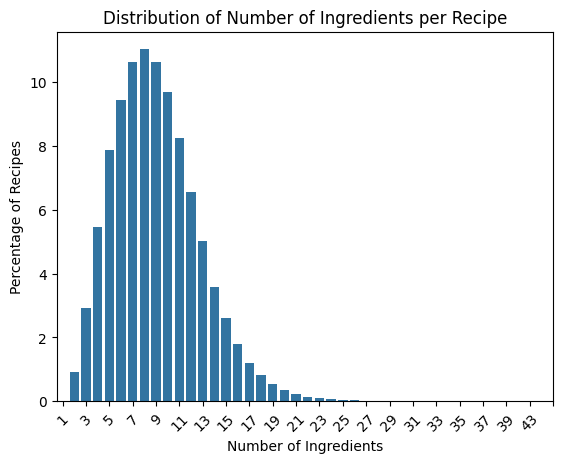

In [12]:
ax = sns.countplot(x=n_ingredients_generated, stat='percent')
ax.set_xticks(np.arange(0, n_ingredients_generated.max()+1, 2))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.title("Distribution of Number of Ingredients per Recipe")
plt.xlabel("Number of Ingredients")
plt.ylabel("Percentage of Recipes")
plt.show()

## Extract `ingredients` classes

In [13]:
mlb_ingredients = MultiLabelBinarizer()
mlb_ingredients.fit(recipes_df['ingredients_list'])
unique_ingredients = mlb_ingredients.classes_
print(f"There are {len(unique_ingredients)} unique ingredients across all recipes.")

There are 14941 unique ingredients across all recipes.


In [14]:
print("Some unique ingredients:")
print(unique_ingredients[:10])

Some unique ingredients:
['1% fat buttermilk' '1% fat cottage cheese' '1% low-fat chocolate milk'
 '1% low-fat milk' '10 bean soup mix' '10 inch low-fat flour tortillas'
 '10" pie crust' '10% cream' '10-inch baked pie shells'
 '10-inch corn tortillas']


## Preprocess the unique list of ingredients

In order to preprocess the unique list of ingredients, we're going to use a **conditional random field model (CRF)** to ingrendients tagging from labelled training data.

To do so, we're going to use the `mtlynch/ingredient-phrase-tagger` docker image.

Steps:
* pull the docker image
```bash
docker pull mtlynch/ingredient-phrase-tagger
```

* run the docker container and train the model on roughly **180k examples** in our snapshot of the **New York Times cooking database**. In order to store the trained model in our local file system, we're going to mount a volume (`artifacts`) to the docker container.
```bash
export ARTIFACT_PATH="src/mangetamain/preprocessing/recipes/artifacts"
mkdir -p $ARTIFACT_PATH

docker run --rm -v $ARTIFACT_PATH:/data mtlynch/ingredient-phrase-tagger bash -c 'bin/train-prod-model /data && cp /data/*.crfmodel /data'
```

* store our unique list of ingredients in the mounted volume `artifacts` in the file `ingredients.txt`.

* run the trained ingredient tagger model on our own ingredients for prediction:
```bash
docker run --rm -v $ARTIFACT_PATH:/data mtlynch/ingredient-phrase-tagger \
bash -c "bin/parse-ingredients.py --model-file /data/nyt-ingredient-tagger.crfmodel < /data/ingredients.txt > /data/parsed_ingredients.json"
```

> * The pretrained ingredient tagger model is stored in `src/mangetamain/preprocessing/recipes/artifacts/nyt-ingredient-tagger.crfmodel`
> * The preprocessed ingredients are stored in `src/mangetamain/preprocessing/recipes/artifacts/parsed_ingredients.json`

In [15]:
# artifacts directory path
artifacts_dir = REPO_ROOT / "src" / "mangetamain" / "preprocessing" / "recipes" / "artifacts"
# artifacts_dir.mkdir(parents=True, exist_ok=True)

# Save the unique ingredients to a text file
ingredients_txt_path = artifacts_dir / "ingredients.txt"
with open(ingredients_txt_path, 'w') as f:
    f.write("\n".join(unique_ingredients))

In [ ]:
client = docker.from_env()
ARTIFACT_PATH = os.path.abspath(artifacts_dir)

client.images.pull("mtlynch/ingredient-phrase-tagger")

# Build the equivalent of: docker run --rm -v ... bash -c "..."
command = [
    "bash", "-c",
    "bin/parse-ingredients.py --model-file /data/nyt-ingredient-tagger.crfmodel "
    "< /data/ingredients.txt > /data/parsed_ingredients.json"
]

container = client.containers.run(
    "mtlynch/ingredient-phrase-tagger",
    command,
    remove=True,
    volumes={ARTIFACT_PATH: {'bind': '/data', 'mode': 'rw'}},
)

In [17]:
# Load the parsed ingredients
parsed_ingredients_path = artifacts_dir / "parsed_ingredients.json"
with open(parsed_ingredients_path, 'r') as f:
    parsed_ingredients = json.load(f)

In [18]:
parsed_ingredients[0]

{'display': "<span class='other'>1% fat</span><span class='name'>buttermilk</span>",
 'input': '1% fat buttermilk',
 'name': 'buttermilk',
 'other': '1% fat'}

The ingredient tagger model extracts the `name` in an `input`.

In [19]:
pd.DataFrame(parsed_ingredients)[['input', 'name']].head(10)

,input,name
0,1% fat buttermilk,buttermilk
1,1% fat cottage cheese,1% fat cottage cheese
2,1% low-fat chocolate milk,chocolate milk
3,1% low-fat milk,milk
4,10 bean soup mix,bean soup mix
5,10 inch low-fat flour tortillas,inch low-fat flour tortillas
6,"10"" pie crust","10"" pie crust"
7,10% cream,10% cream
8,10-inch baked pie shells,pie shells
9,10-inch corn tortillas,corn tortillas


In [20]:
original_ingredients = [ing['input'] for ing in parsed_ingredients]
assert len(original_ingredients) == len(unique_ingredients), \
    "The parsed ingredients and the original unique list of ingredients have different number of ingredients"

In [21]:
for idx, ing in enumerate(original_ingredients):
    if ing not in unique_ingredients:
        print(f"Ingredient not found in unique ingredients: {ing} at index {idx}")

In [22]:
not_matching_mapping = (original_ingredients != unique_ingredients)
print(f"There are {not_matching_mapping.sum()} ingredients that don't match\n")
if not_matching_mapping.any():
    for (is_match, parsed_org_ing, ing) in zip(not_matching_mapping, original_ingredients, unique_ingredients):
        if is_match:
            print(f"{ing} <- vs -> {parsed_org_ing}")

There are 0 ingredients that don't match



In [23]:
ingredients_without_name = [ingredient['input'] for ingredient in parsed_ingredients if 'name' not in ingredient]
print(f"There are {len(ingredients_without_name)} ingredients without a 'name' field.")
ingredients_without_name[:10]

There are 57 ingredients without a 'name' field.


['acid blend',
 'agave',
 'apricots in juice',
 'blackberry all-fruit spread',
 'bottom round steaks',
 'brine',
 'brummel and brown spread',
 'casing',
 'casings',
 'citrus slices']

In [24]:
# Create a list of parsed ingredient names, using the original input if 'name' is missing
# This will help in identifying any ingredients that were not properly parsed
# indexes of ingredients without a name are stored
list_parsed_ingredients = []
empty_flags_parsing = [False] * len(parsed_ingredients)
for i, ingredient in enumerate(parsed_ingredients):
    if ingredient and 'name' in ingredient:
        list_parsed_ingredients.append(ingredient['name'])
    else:
        list_parsed_ingredients.append(ingredient['input'])
        empty_flags_parsing[i] = True

Some **post-processing**

In [ ]:
# Blacklist tokens that sometimes survive and are not main ingredients
EXTRA_TOKEN_BLACKLIST = {
    "inch", "inches", "deep", "low", "fat", "fresh", "large", "small",
    "medium", "thin", "diced", "sliced", "chopped", "piece", "pieces"
}

# Precompile regex patterns (saves overhead)
RE_PUNCT = re.compile(r"[^a-z\s-]")
RE_SPACES = re.compile(r"\s+")

def preprocess_text(text: str) -> str:
    """Fast text cleanup before NLP."""
    text = text.lower()
    text = RE_PUNCT.sub(" ", text)       # remove punctuation
    text = RE_SPACES.sub(" ", text).strip()
    return text

def extract_main_ingredients(texts: List[str]):
    """Batch process multiple texts with spaCy for speed."""
    cleaned = []
    empty_indices = [False] * len(texts)

    # Pre-clean all texts before sending to spaCy (lighter and faster)
    preprocessed = [preprocess_text(t) for t in texts]

    for doc in nlp.pipe(preprocessed, batch_size=64):
        main_tokens = [
            token.lemma_.lower().strip()
            for token in doc
            if token.pos_ in {"NOUN", "PROPN"}
            and not token.is_stop
            and len(token) > 1
            and token.lemma_.lower().strip() not in EXTRA_TOKEN_BLACKLIST
        ]

        # Remove duplicates while preserving order
        result = "-".join(dict.fromkeys(main_tokens))
        if not result:
            empty_indices[len(cleaned)] = True
            result = doc.text
        cleaned.append(result)

    return cleaned, empty_indices

In [26]:
cleaned_ingredients, empty_flags = extract_main_ingredients(list_parsed_ingredients)

In [27]:
print(f"After cleaning, there are {np.sum(empty_flags)} empty ingredients.")
print("Examples of original ingredients that became empty after cleaning:")
print(np.array(unique_ingredients)[empty_flags][:10])

After cleaning, there are 404 empty ingredients.
Examples of original ingredients that became empty after cleaning:
['7-up' 'absinthe' 'achiote' 'acorn' 'acorn squash' 'acorns'
 'adobo seasoning' 'agave' 'alcaparrado' 'allspice']


In [28]:
empty_flags_combined = list(
    np.array(empty_flags) * np.array(empty_flags_parsing)
)
print(f"{np.sum(empty_flags_combined)} ingredients were reduced to empty either after parsing or cleaning:")
print(np.array(unique_ingredients)[empty_flags_combined])

7 ingredients were reduced to empty either after parsing or cleaning:
['agave' 'brine' 'casing' 'preserves' 'ribbon' 'spelt' 'steaks']


In [31]:
final_ingredients = cleaned_ingredients.copy()
# Only keep ingredients that are not empty after both parsing and cleaning
final_ingredients = np.array(final_ingredients)
final_ingredients[empty_flags_combined] = ''
final_ingredients = list(final_ingredients)

unique_final_ingredients = set(final_ingredients)
unique_final_ingredients.remove('')  # remove empty string if present
print(f"Reduced from {len(unique_ingredients)} to {len(unique_final_ingredients)} unique cleaned ingredients.")
print(f"Total reduction of {(len(unique_ingredients) - len(unique_final_ingredients)) / len(unique_ingredients) * 100:.2f}% ingredients.")

Reduced from 14941 to 8041 unique cleaned ingredients.
Total reduction of 46.18% ingredients.
